In [146]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
from sklearn.metrics import mean_squared_error

In [147]:
model = tf.keras.models.load_model('model_epoch_94.h5')
model.summary()  # optional

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │      2,688 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1000, 64)  │      1,344 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 128)  │     41,088 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 128) │     73,856 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 128)  │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 128)  │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 128) │    147,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]   

 Total params: 449,475 (1.71 MB)

 Trainable params: 448,449 (1.71 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 2 (12.00 B)

In [148]:
df = pd.read_csv('test_ID_dataset.csv')

In [149]:
smiles_list = df['SMILES'].tolist()
protein_list = df['target_sequence'].tolist()

In [150]:
# Encode SMILES
smiles_chars = sorted(set(''.join(df['SMILES'])))
char_to_int_smiles = {c: i + 1 for i, c in enumerate(smiles_chars)}

def encode_smiles(smiles):
    return [char_to_int_smiles.get(c, 0) for c in smiles]

df['smiles_encoded'] = df['SMILES'].apply(encode_smiles)

# Encode protein sequence
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i + 1 for i, aa in enumerate(aa_list)}

def encode_protein(seq):
    return [aa_to_int.get(aa, 0) for aa in seq]

df['protein_encoded'] = df['target_sequence'].apply(encode_protein)

# Pad
max_len_smiles = 100
max_len_protein = 1000

X_smiles_test = pad_sequences(df['smiles_encoded'], maxlen=max_len_smiles, padding='post')
X_protein_test = pad_sequences(df['protein_encoded'], maxlen=max_len_protein, padding='post')
y_test = df['Kd'].values

In [151]:
# Predict
y_pred = model.predict([X_smiles_test, X_protein_test]).flatten()

192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step


In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error , root_mean_squared_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 0.7187
Mean Absolute Error: 0.5393
Root Mean Squared Error: 0.8478


In [153]:
import pandas as pd
import numpy as np
from collections import Counter
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

y_true = y_test
sequences = df['target_sequence'].tolist()
smiles = df['SMILES'].tolist()

In [154]:
df = pd.DataFrame({
    'sequence': sequences,
    'smiles' : smiles,  # list of SMILES or protein sequences
    'y_true': y_true,
    'y_pred': y_pred,
    'target_id': df['target_id']
})

df['error'] = df['y_pred'] - df['y_true']
df['abs_error'] = df['error'].abs()

In [155]:
df.head()

,sequence,smiles,y_true,y_pred,target_id,error,abs_error
0,MAHAMENSWTISKEYHIDEEVGFALPNPQENLPDFYNDWMFIAKHL...,Brc1c[nH]c(c1)C(=O)NCc1cccc(Cn2cnc3ccccc23)c1,6.259637,4.068235,P14902,-2.191402,2.191402
1,MSFLPGMTPVTLSNFSWALEDRMLEGNSTTTPTRQLMPLVVVLSSV...,Brc1ccc(cc1)C(CCNC(=N)NCCCc1cnc[nH]1)c1ccccn1,6.919987,6.654675,P31389,-0.265312,0.265312
2,MNRPHSCLSFCWMYFAASGIRAVETANGKYAQKLFSDLFEDYSSAL...,Brc1ccc(cc1)C1CC2CCC1N2,10.346787,10.441879,P43144,0.095092,0.095092
3,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,Brc1ccc(cc1)[C@@H]1[C@H]2CN(C(=O)C[C@@H]2CS[C@...,5.705534,6.580748,Q00987,0.875214,0.875214
4,MDTSGHFHDSGVGDLDEDPKCPCPSSGDEQQQQQQPPPPSAPPAVP...,Brc1ccc2CCCC(Nc3nc4ccccc4[nH]3)c2c1,7.958607,7.294353,P70605,-0.664254,0.664254


In [156]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Return full species name instead of boolean
def get_species_name(uniprot_id):
    try:
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            organism = data.get("organism", {}).get("scientificName", "")
            return uniprot_id, organism
    except Exception:
        pass
    return uniprot_id, "Unknown"

def get_species_for_all(protein_ids, max_workers=20):
    results = {}
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_species_name, pid): pid for pid in protein_ids}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Getting species"):
            pid, species = future.result()
            results[pid] = species
    return results


# Get unique target protein IDs
protein_ids = df['target_id'].dropna().unique().tolist()

# Get species name for each UniProt ID
species_results = get_species_for_all(protein_ids)

# Map back to your DataFrame
df['species'] = df['target_id'].map(species_results)

Getting species: 100%|██████████| 1161/1161 [00:57<00:00, 20.04it/s]


C:\Users\NongNam\AppData\Local\Temp\ipykernel_13516\250234424.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


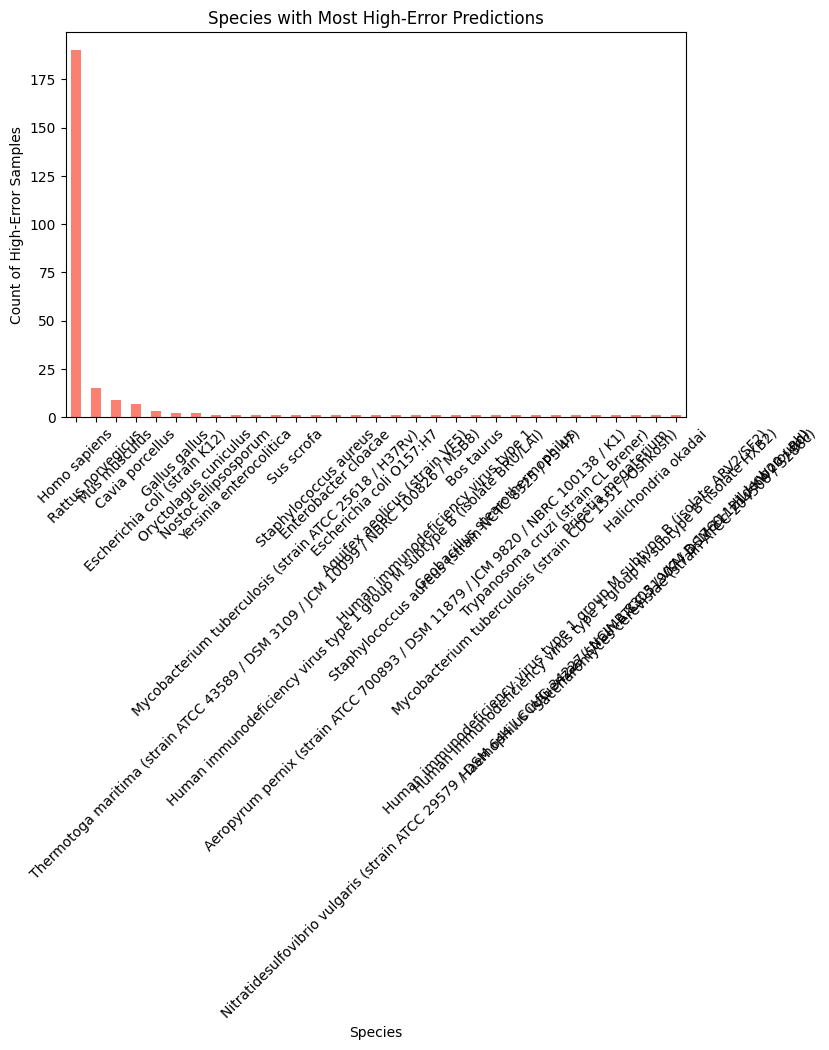

In [157]:
import pandas as pd

# Step 1: Define a threshold for what you consider a "bad" prediction
threshold = 2.0  # adjust as needed (e.g., absolute error > 2)

# Step 2: Filter rows with high errors
high_error_df = df[df['abs_error'] > threshold]

# Step 3: Count species in those high-error rows
species_error_counts = high_error_df['species'].value_counts()

# Step 4: (Optional) Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
species_error_counts.plot(kind='bar', color='salmon')
plt.title('Species with Most High-Error Predictions')
plt.ylabel('Count of High-Error Samples')
plt.xlabel('Species')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def get_pfam_domains(uniprot_id):
    try:
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            domains = []
            for feature in data.get('features', []):
                if feature.get('type') == 'Domain':
                    desc = feature.get('description', '')
                    if desc:
                        domains.append(desc)
            return domains
        else:
            return []
    except:
        return []


uniprot_ids = df['target_id'].unique().tolist()
results_dict = {}

# Run with thread workers
with ThreadPoolExecutor(max_workers=16) as executor:
    futures = {executor.submit(get_pfam_domains, uid): uid for uid in uniprot_ids}

    for future in tqdm(as_completed(futures), total=len(futures)):
        uid = futures[future]
        try:
            results_dict[uid] = future.result()
        except Exception as e:
            results_dict[uid] = []
            print(f"Error with {uid}: {e}")

# Map back to original dataframe
df['pfam_domains'] = df['target_id'].map(results_dict)


100%|██████████| 1161/1161 [01:06<00:00, 17.37it/s]


In [159]:
from collections import Counter

# Expand rows if multiple domains per protein
df_exploded = df.explode('pfam_domains')

# Group by domain
pfam_errors = df_exploded.groupby('pfam_domains')['abs_error'].mean().sort_values(ascending=False)

# Show top 10 most error-prone domains
print(pfam_errors.head(10))

pfam_domains
Peptidase M2 2                       3.956181
Peptidase M2 1                       3.956181
Carrier                              2.902058
GOLD                                 2.604509
MGS-like                             2.540280
Glutamine amidotransferase type-1    2.540280
ATP-grasp 2                          2.540280
ATP-grasp 1                          2.540280
Integrase-type                       2.483080
MYST-type HAT                        2.326969
Name: abs_error, dtype: float64


In [160]:
domain_errors = df_exploded.groupby('pfam_domains')['abs_error'].mean().sort_values(ascending=False)
best_domains = domain_errors.sort_values().head(10)
print(best_domains)


pfam_domains
EGF-like 6                    0.024504
EGF-like 5                    0.024504
EGF-like 4                    0.024504
Alpha-type protein kinase     0.028459
YjeF C-terminal               0.032864
YjeF N-terminal               0.032864
MRH                           0.047966
KEN                           0.055560
Myosin N-terminal SH3-like    0.069645
Transferrin-like 2            0.071290
Name: abs_error, dtype: float64


In [187]:
from collections import Counter

def extract_kmers(seq, k=10):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

df['protein_kmers'] = df['sequence'].apply(lambda s: extract_kmers(s, k=5))

def extract_smiles_kmers(smiles, k=5):
    return [smiles[i:i+k] for i in range(len(smiles) - k + 1)]

df['smiles_subs'] = df['smiles'].apply(lambda s: extract_smiles_kmers(s, k=5))

# Define high-error and low-error sets (top 10% and bottom 10%)
high_error = df[df['abs_error'] > df['abs_error'].quantile(0.9)]
low_error = df[df['abs_error'] < df['abs_error'].quantile(0.1)]

# Flatten kmers and substructures for both sets
def flatten_kmers_subs(df_subset):
    flat_protein_kmers = [k for kmers in df_subset['protein_kmers'] for k in kmers]
    flat_subs = [s for subs in df_subset['smiles_subs'] for s in subs]
    return flat_protein_kmers, flat_subs

high_protein_kmers, high_smiles_subs = flatten_kmers_subs(high_error)
low_protein_kmers, low_smiles_subs = flatten_kmers_subs(low_error)

In [188]:
# Print top motifs and substructures for high-error samples
print("Top protein motifs in high-error samples:")
print(Counter(high_protein_kmers).most_common(10))

# Print top motifs and substructures for low-error samples
print("\nTop protein motifs in low-error samples:")
print(Counter(low_protein_kmers).most_common(10))

print("\nTop SMILES substructures in high-error samples:")
print(Counter(high_smiles_subs).most_common(10))

print("\nTop SMILES substructures in low-error samples:")
print(Counter(low_smiles_subs).most_common(10))


Top protein motifs in high-error samples:
[('QQQQQ', 130), ('PPPPP', 94), ('EEEEE', 90), ('DFGLA', 68), ('GGGGG', 57), ('LLLLL', 53), ('SDVWS', 52), ('SSSSS', 51), ('FGLAR', 49), ('HRDLA', 47)]

Top protein motifs in low-error samples:
[('HRDLK', 170), ('EEEEE', 163), ('DFGLA', 140), ('RDLKP', 138), ('VHRDL', 125), ('HRDIK', 115), ('DLKPE', 110), ('LKPEN', 110), ('MAPEV', 97), ('SDVWS', 87)]

Top SMILES substructures in high-error samples:
[('C(=O)', 926), ('[C@H]', 694), ('[C@@H', 586), ('C@@H]', 586), ('@H](C', 508), ('C@H](', 483), ('O)[C@', 470), ('NC(=O', 408), ('(=O)N', 389), ('@@H](', 370)]

Top SMILES substructures in low-error samples:
[('c1ccc', 421), ('C(=O)', 406), ('(=O)N', 256), ('c3ccc', 251), ('c2ccc', 219), ('1ccc(', 216), ('1)-c1', 198), ('ccc(C', 172), ('c(F)c', 169), (')-c1c', 156)]


In [189]:
from collections import Counter

# Count motifs and substructures
high_prot_counts = Counter(high_protein_kmers)
low_prot_counts = Counter(low_protein_kmers)
high_smiles_counts = Counter(high_smiles_subs)
low_smiles_counts = Counter(low_smiles_subs)

# Get top N
top_n = 20
top_high_prot = dict(high_prot_counts.most_common(top_n))
top_low_prot = dict(low_prot_counts.most_common(top_n))
top_high_smiles = dict(high_smiles_counts.most_common(top_n))
top_low_smiles = dict(low_smiles_counts.most_common(top_n))

### Remove shared keys ####
unique_high_prot = {k: v for k, v in top_high_prot.items() if k not in top_low_prot}
unique_low_prot = {k: v for k, v in top_low_prot.items() if k not in top_high_prot}

unique_high_smiles = {k: v for k, v in top_high_smiles.items() if k not in top_low_smiles}
unique_low_smiles = {k: v for k, v in top_low_smiles.items() if k not in top_high_smiles}

# Print top motifs and substructures for high-error samples
print("Top protein motifs in high-error samples:")
print(Counter(unique_high_prot).most_common(10))

print("\nTop SMILES substructures in high-error samples:")
print(Counter(unique_high_smiles).most_common(10))

# Print top motifs and substructures for low-error samples
print("\nTop protein motifs in low-error samples:")
print(Counter(unique_low_prot).most_common(10))

print("\nTop SMILES substructures in low-error samples:")
print(Counter(unique_low_smiles).most_common(10))

Top protein motifs in high-error samples:
[('QQQQQ', 130), ('PPPPP', 94), ('LLLLL', 53), ('SSSSS', 51), ('DDDDD', 46), ('QPPPP', 44), ('KKKKK', 42), ('QQPPP', 39)]

Top SMILES substructures in high-error samples:
[('[C@@H', 586), ('C@@H]', 586), ('@H](C', 508), ('C@H](', 483), ('O)[C@', 470), ('@@H](', 370), ('=O)[C', 338), (')[C@H', 326), ('(=O)[', 299), (')C(=O', 270)]

Top protein motifs in low-error samples:
[('RDLKP', 138), ('VHRDL', 125), ('HRDIK', 115), ('DLKPE', 110), ('LKPEN', 110), ('MAPEV', 97), ('APEVL', 87), ('DFGLS', 78)]

Top SMILES substructures in low-error samples:
[('c3ccc', 251), ('1ccc(', 216), ('1)-c1', 198), ('ccc(C', 172), ('c(F)c', 169), (')-c1c', 156), ('2ccc(', 151), ('-c1cc', 149), ('c(Nc3', 142), ('3ccc(', 141)]


In [197]:
top_high_motifs = ['QQQQQ', 'PPPPP', 'LLLLL', 'SSSSS', 'DDDDD', 
                   'QPPPP', 'KKKKK', 'QQPPP']

top_low_motifs = ['RDLKP', 'VHRDL', 'HRDIK', 'DLKPE', 'LKPEN', 
                  'MAPEV', 'APEVL', 'DFGLS']

# Create result counts
def count_motifs_in_sequences(sequences, motifs):
    motif_counts = {}
    for motif in motifs:
        motif_counts[motif] = sequences.apply(lambda s: motif in s).sum()
    return motif_counts

# Example: count in the no-split protein dataset
protein_counts_high = count_motifs_in_sequences(df['sequence'], top_high_motifs)
protein_counts_low = count_motifs_in_sequences(df['sequence'], top_low_motifs)

print("High-error motif counts in full sequences:")
for motif, count in protein_counts_high.items():
    print(f"{motif}: {count}")

print("\nLow-error motif counts in full sequences:")
for motif, count in protein_counts_low.items():
    print(f"{motif}: {count}")


High-error motif counts in full sequences:
QQQQQ: 249
PPPPP: 212
LLLLL: 188
SSSSS: 307
DDDDD: 51
QPPPP: 109
KKKKK: 91
QQPPP: 66

Low-error motif counts in full sequences:
RDLKP: 709
VHRDL: 669
HRDIK: 576
DLKPE: 538
LKPEN: 540
MAPEV: 597
APEVL: 312
DFGLS: 425


In [167]:
top_high_subs = ['[C@@H', 'C@@H]', '@H](C', 'C@H](', 'O)[C@', '@@H](', '=O)[C', ')[C@H', '(=O)[', ')C(=O']
top_low_subs = ['c3ccc', '1ccc(', '1)-c1', 'ccc(C', 'c(F)c', ')-c1c', '2ccc(', '-c1cc', 'c(Nc3', '3ccc(']

def count_substructures_in_smiles(smiles_list, substructures):
    counts = {}
    for sub in substructures:
        counts[sub] = sum(sub in smi for smi in smiles_list)
    return counts

# Assuming no_split_df has 'smiles' column
smiles_counts_high = count_substructures_in_smiles(df['smiles'], top_high_subs)
smiles_counts_low = count_substructures_in_smiles(df['smiles'], top_low_subs)

print("High-error substructure counts in full SMILES:")
for sub, count in smiles_counts_high.items():
    print(f"{sub}: {count}")

print("\nLow-error substructure counts in full SMILES:")
for sub, count in smiles_counts_low.items():
    print(f"{sub}: {count}")


High-error substructure counts in full SMILES:
[C@@H: 1547
C@@H]: 1547
@H](C: 1046
C@H](: 1090
O)[C@: 667
@@H](: 1125
=O)[C: 410
)[C@H: 618
(=O)[: 423
)C(=O: 1313

Low-error substructure counts in full SMILES:
c3ccc: 1883
1ccc(: 1553
1)-c1: 591
ccc(C: 900
c(F)c: 1024
)-c1c: 732
2ccc(: 1006
-c1cc: 652
c(Nc3: 589
3ccc(: 798


In [192]:
no_split_df = pd.read_csv('no_split_kd.csv') #from dataset

In [193]:
top_high_motifs = ['QQQQQ', 'PPPPP', 'LLLLL', 'SSSSS', 'DDDDD', 
                   'QPPPP', 'KKKKK', 'QQPPP']

top_low_motifs = ['RDLKP', 'VHRDL', 'HRDIK', 'DLKPE', 'LKPEN', 
                  'MAPEV', 'APEVL', 'DFGLS']

# Create result counts
def count_motifs_in_sequences(sequences, motifs):
    motif_counts = {}
    for motif in motifs:
        motif_counts[motif] = sequences.apply(lambda s: motif in s).sum()
    return motif_counts

# Example: count in the no-split protein dataset
protein_counts_high = count_motifs_in_sequences(no_split_df['target_sequence'], top_high_motifs)
protein_counts_low = count_motifs_in_sequences(no_split_df['target_sequence'], top_low_motifs)

print("High-error motif counts in full sequences:")
for motif, count in protein_counts_high.items():
    print(f"{motif}: {count}")

print("\nLow-error motif counts in full sequences:")
for motif, count in protein_counts_low.items():
    print(f"{motif}: {count}")


High-error motif counts in full sequences:
QQQQQ: 2627
PPPPP: 2050
LLLLL: 1970
SSSSS: 2882
DDDDD: 478
QPPPP: 1193
KKKKK: 871
QQPPP: 836

Low-error motif counts in full sequences:
RDLKP: 7032
VHRDL: 6933
HRDIK: 6055
DLKPE: 5378
LKPEN: 5380
MAPEV: 5973
APEVL: 3216
DFGLS: 4350


In [170]:
top_high_subs = ['[C@@H', 'C@@H]', '@H](C', 'C@H](', 'O)[C@', '@@H](', '=O)[C', ')[C@H', '(=O)[', ')C(=O']
top_low_subs = ['c3ccc', '1ccc(', '1)-c1', 'ccc(C', 'c(F)c', ')-c1c', '2ccc(', '-c1cc', 'c(Nc3', '3ccc(']

def count_substructures_in_smiles(smiles_list, substructures):
    counts = {}
    for sub in substructures:
        counts[sub] = sum(sub in smi for smi in smiles_list)
    return counts

# Assuming no_split_df has 'smiles' column
smiles_counts_high = count_substructures_in_smiles(no_split_df['SMILES'], top_high_subs)
smiles_counts_low = count_substructures_in_smiles(no_split_df['SMILES'], top_low_subs)

print("High-error substructure counts in full SMILES:")
for sub, count in smiles_counts_high.items():
    print(f"{sub}: {count}")

print("\nLow-error substructure counts in full SMILES:")
for sub, count in smiles_counts_low.items():
    print(f"{sub}: {count}")


High-error substructure counts in full SMILES:
[C@@H: 14278
C@@H]: 14278
@H](C: 10102
C@H](: 10502
O)[C@: 6185
@@H](: 10546
=O)[C: 3965
)[C@H: 5747
(=O)[: 4035
)C(=O: 12503

Low-error substructure counts in full SMILES:
c3ccc: 18513
1ccc(: 15648
1)-c1: 6882
ccc(C: 8802
c(F)c: 10052
)-c1c: 8025
2ccc(: 9840
-c1cc: 6990
c(Nc3: 5746
3ccc(: 7683
